# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [1]:
# 1.1 Place imports here
from typing import List, Optional
import re
import os
from dotenv import load_dotenv
from openai import AzureOpenAI
from collections import defaultdict
from dataclasses import dataclass
import json
import pandas as pd  # Ensure pandas is imported
from tqdm import tqdm 
from typing import List, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt

## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [2]:
# 2.1 Data Configuration
DATASET = "geneturing"
#DATASET = "genehop"
DATA_PATH = f"data/{DATASET}.json"

In [3]:
# 2.2 Model Configuration
# Load environment variables from .env file
load_dotenv()

# Set up OpenAI API client
# NOTE: HERE we dont ever save the API key as a variable so it never gets printed
api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")
api_deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

In [4]:
# 2.3 Evaluation and Logging Configuration
RESULT_FILE = f"{DATASET}_results.csv"

## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [5]:
# 3.1 Load the JSON file
# Load the data here
try:
    with open(DATA_PATH, 'r') as f:
        data = json.load(f)
    print("JSON file loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file {DATA_PATH} was not found.")
    data = {} # Initialize data as an empty dict to prevent further errors
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from the file {DATA_PATH}.")
    data = {}

# Build the TASKS variable here
TASKS = set()
if data: # Check if data was loaded successfully
    for task_name in data.keys():
        TASKS.add(task_name)
# You can print the TASKS to verify
print("\nTasks found:")
for task in TASKS:
    print(task)

JSON file loaded successfully!

Tasks found:
Protein-coding genes
Gene SNP association
Gene alias
Gene name conversion
SNP location
Human genome DNA aligment
Gene disease association
Multi-species DNA aligment
Gene location


In [23]:
def collect_rows(data):
    rows = [
        {'task': task_name, 'question': question, 'answer': answer}
        for task_name, task_data in data.items()
        for question, answer in task_data.items()
    ]
    return rows

rows = collect_rows(data)


In [7]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above




In [24]:
print(rows)

[{'task': 'Gene alias', 'question': 'What is the official gene symbol of LMP10?', 'answer': 'PSMB10'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of SNAT6?', 'answer': 'SLC38A6'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of IMD20?', 'answer': 'FCGR3A'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of C20orf195?', 'answer': 'FNDC11'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of CXorf40B?', 'answer': 'EOLA2'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of QSCN6L1?', 'answer': 'QSOX2'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of OR11-86?', 'answer': 'OR10A2'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of NPAP60L?', 'answer': 'NUP50'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of AF10?', 'answer': 'MLLT10'}, {'task': 'Gene alias', 'question': 'What is the official gene symbol of

In [8]:
# 3.3 Create the pandas dataframe from the collection of rows
dataset = pd.DataFrame(rows)

# Display the dataframe
print(dataset.head())  # Display the first few rows of the dataframe


           task                                           question answer
0  SNP location  Which chromosome does SNP rs1430464868 locate ...  chr13
1  SNP location  Which chromosome does SNP rs545148486 locate o...  chr16
2  SNP location  Which chromosome does SNP rs895485955 locate o...  chr19
3  SNP location  Which chromosome does SNP rs1376217783 locate ...  chr11
4  SNP location  Which chromosome does SNP rs1420724913 locate ...  chr16


## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [9]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_message = {
        "role": "system",
        "content": """You are a knowledgeable assistant specialized in genomics. 
        Your task is to provide accurate and concise answers to genomic questions using NCBI Web APIs. 
        Please ensure your responses are clear and informative, and follow the format: 'Answer: [your answer]'. 
        Please only provide the actual answers without any additional text or explanation. 
        If you do it well, I will give you a reward."""
    }


### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [10]:

os.environ['no_proxy'] = '*'

In [11]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"), # Always use it just in time
    api_version=api_version,
    azure_endpoint=api_base,
    timeout=10,
    max_retries=3,
)



In [12]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Howdy"},
]

response = client.chat.completions.create(
    model=api_deployment,
    messages=messages
)

parsed_response = response.choices[0].message.content

print(parsed_response)

Howdy! How can I help you today?


In [13]:
example_messages = [
    {
        "role": "user",
        "content": "What is the official gene symbol of LMP10?"
    },

    {
        "role": "assistant",
        "content": "Answer: PSMB10"
    },
    {
        "role": "user",
        "content":"Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT"
    },
    {
        "role": "assistant",
        "content": "Answer: chr15:91950805-91950932"
    },
    {
        "role": "user",
        "content": "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT"
    },
    {
        "role": "assistant",
        "content": "Answer: worm"
    },
    {
        "role": "user",
        "content" : "Convert ENSG00000215251 to official gene symbol."
    },
    {
        "role": "assistant",
        "content": "Answer: FASTKD5"
    },
    {
        "role": "user",
        "content": "Is SSBP3-AS1 a protein-coding gene?"
    },
    {
        "role": "assistant",
        "content": "Answer: na"
    }
]

### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [14]:
# 4.4 Implementing the model request function
def query_model(
    client: AzureOpenAI, 
    system_message: dict, 
    few_shot_examples: List[dict], 
    user_query: str
) -> str:
    messages = [system_message] + few_shot_examples + [{"role": "user", "content": user_query}]
    
    response = client.chat.completions.create(
        model=api_deployment,
        messages=messages,  # Adjust temperature for response variability
        
    )
    
    answer = response.choices[0].message.content
    return answer.split("Answer: ")[-1].strip()  # Extract everything after 'Answer :'


## 5. Metrics

The GeneTuring dataset has several task specific evaluation metrics that are variations on exact match depending on the expected cardinality of the output.

Please inspect `evaluate.py` from the GeneGPT repository to find the metric functions and implement them here.

Original functions: [evaluate.py](https://github.com/ncbi/GeneGPT/blob/main/evaluate.py)

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [15]:
# 5.1 Implement metrics

def exact_match(pred: str, true: str) -> float:
    return 1.0 if pred == true else 0.0

def gene_disease_association(pred: list, true: str) -> float:
    if not true:  # Avoid division by zero
        return 0.0
    true_genes = true.split(", ")
    correct_count = sum(1 for item in pred if item in true_genes)
    return correct_count / len(true_genes) if len(true_genes) > 0 else 0.0

def disease_gene_location(pred: list, true: list) -> float:
    if not true:  # Avoid division by zero
        return 0.0 
    correct_count = sum(1 for item in pred if item in true)
    return correct_count / len(true)

def human_genome_dna_alignment(pred: str, true: str) -> float:
    pred_chr = pred.split(":")[0]
    pred_pos = pred.split(":")[1]
    true_chr = true.split(":")[0]
    true_pos = true.split(":")[1]
    
    if pred_chr != true_chr:
        return 0.0
    elif pred_pos != true_pos:
        return 0.5
    else:
        return 1.0
    




Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [16]:
# 5.2 Implement the answer mapping function
def get_answer(answer: str, task: str):
	mapper = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}

	if task == 'SNP location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene location':
		answer = answer.strip().split()[-1]
		if 'chromosome' in answer:
			answer = 'chr' + answer.split('chromosome')[-1].strip()  
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene disease association':
		answer = answer.split(', ')

	elif task == 'Disease gene location':
		answer = answer.split(', ')

	elif task == 'Protein-coding genes':
		if answer == 'Yes':
			answer = 'true'
		elif answer == 'No':
			answer = 'na'

	elif task == 'Multi-species DNA aligment':
		match = re.search(r'\((.*?)\)', answer)
		if match:
			answer = match.group(1)

		answer = mapper.get(answer, answer)

	return answer#.lower() if isinstance(answer, str) else answer

#Calculate the score for a prediction against the true answer.
def get_score (pred: str, true: str, task: str) -> float:
	metric_task_map = defaultdict(exact_match, {
    "Gene disease association": gene_disease_association,
    "disease gene location": disease_gene_location,
    "Human genome DNA aligment": human_genome_dna_alignment})
	
	if task in metric_task_map:
		return metric_task_map[task](pred, true)
	else:
		return exact_match(pred, true)  # Default to exact match if task not found

## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [17]:

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]
    processed_prediction: Optional[str]
    score: Optional[float]
    success: bool

def save_results(results: List[Result], results_csv_filename: str) -> None:
    """Save the results to a CSV file."""
    df = pd.DataFrame([result.__dict__ for result in results])
    df.to_csv(results_csv_filename, index=False)
    



In [18]:
# 6.2 Loop over the dataset with a progress bar
# Initialize the results list
results = []

for index, data_row in tqdm(dataset.iterrows(),
                            desc=f"Processing Rows", 
                            total=len(dataset)):
    try:
        # Assuming `query_model` is defined in a previous cell
        question_to_ask = data_row['question']

        # Call your model querying function
        response_from_model = query_model(client, system_message, example_messages, question_to_ask)

        # Process the answer
        processed_answer_from_model = get_answer(response_from_model, data_row['task'])
        # print(f"Processing index {index} (Question: '{question_to_ask}'):")
        # print(f"raw prediction for index {index}: '{response_from_model}'")
        # print(f"Processed answer for index {index}: '{processed_answer_from_model}'")
        # print(f"True answer for index {index}: '{data_row['answer']}'")

        # Store the result
        s = get_score(processed_answer_from_model, data_row['answer'], data_row['task'])
        results.append(Result(
            id=index,
            task=data_row['task'],
            question=question_to_ask,
            answer=data_row['answer'],
            raw_prediction=response_from_model,
            processed_prediction=processed_answer_from_model,
            score=s,
            success=True
        ))
        # running_score = (running_score *index + s)/ (index + 1)

    except Exception as e:
        print(f"Error processing index {index} (Question: '{data_row.get('question', 'N/A')}'): {e}")
    
        # Store an error result
        results.append(Result(
            id=index,
            task=data_row['task'],
            question=question_to_ask,
            answer=data_row.get('answer', 'N/A'),
            raw_prediction=None,
            processed_prediction=None,
            score=None,#exact_match(processed_answer_from_model, data_row['answer']),
            success=False
        ))

Processing Rows:   0%|          | 0/50 [00:00<?, ?it/s]

Processing Rows: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


In [19]:
# 6.3 Save the results
save_results(results, RESULT_FILE)


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [20]:
# 7.1 Calculate the fraction of successful predictions
successful_predictions = sum(result.success for result in results)/ len(results) if results else 0
print(f"Fraction of successful predictions: {successful_predictions:.2%}")

Fraction of successful predictions: 100.00%


Now let's calculate both the overall score as well as the score by task.

In [21]:
# 7.2 Calculate the overall score and the score by task
task_scores = defaultdict(list)
for result in results:
    if result.success:
        task_scores[result.task].append(result.score)
for task, scores in task_scores.items():
    task_scores[task] = sum(scores) / len(scores) if scores else 0
overall_score = sum(result.score for result in results if result.success) / len(results) if results else 0

Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

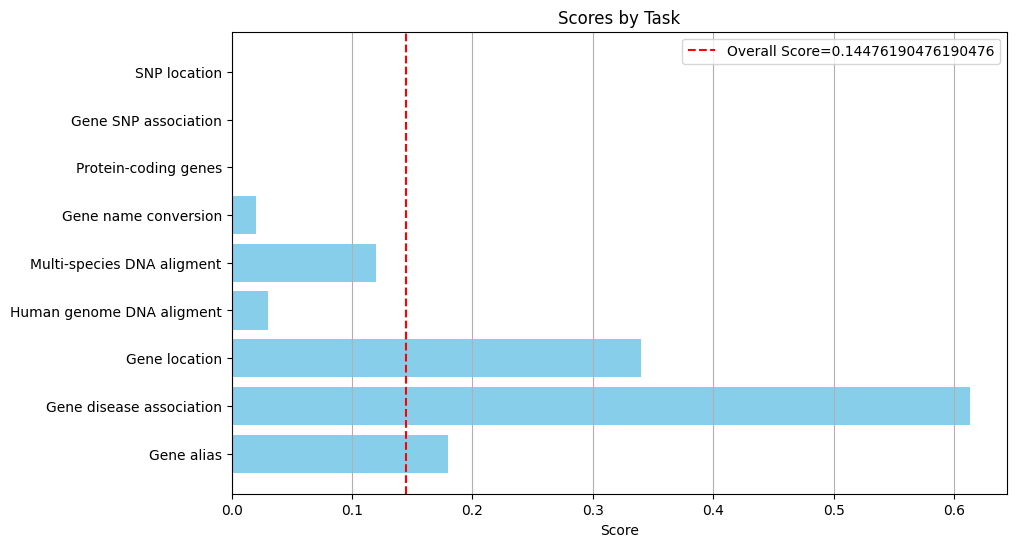

In [45]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
def plot_scores_by_task(task_scores: dict, overall_score: float,imag_path:str) -> None:
    tasks = list(task_scores.keys())
    scores = list(task_scores.values())

    plt.figure(figsize=(10, 6))
    plt.barh(tasks, scores, color='skyblue')  # Changed from barh to bar
    plt.axvline(overall_score, color='red', linestyle='--', label=f'Overall Score={overall_score}')  # Changed from axvline to axhline
    plt.xlabel('Score')  # Changed xlabel to ylabel
    plt.title('Scores by Task')
    plt.legend()
    plt.grid(axis='x')  # Changed from axis='x' to axis='y'
    plt.savefig(imag_path)
    plt.show()
plot_scores_by_task(task_scores, overall_score,imag_path= f"{DATASET}_scores_by_task.png")

In [47]:
import mlflow
import argparse
import mlflow
from pydantic import AnyUrl

parser = argparse.ArgumentParser(description="gene tuning MLflow.")
parser.add_argument(
    "http://198.215.61.34:8153/",
    required=True,
    help="Zimei Chen"
)
args = parser.parse_args()
mlflow_uri = AnyUrl(args.tracking_uri)

# 1 - Tell MLflow where to send data
mlflow.set_tracking_uri(str(mlflow_uri))
mlflow.set_experiment(args.name)

with mlflow.start_run(run_name="ipynb_run") as run:
    # Log parameters
    
    print(f"Logged to MLflow run → {run.info.run_id}")
    mlflow.log_param("num_tasks",len(task_scores))
    
    # Log avg_scores as a param (flattened)
    for _, row in task_scores.iterrows():
        mlflow.log_metric(row["task"], row["score"])

    # Plot and save bar chart
    imag_path = "per_task_scores.png"
    plot_scores_by_task(task_scores, overall_score,imag_path)

    
    plt.savefig(imag_path)
    mlflow.log_artifact(imag_path)

    # log the csv predictions
    mlflow.log_artifact('output/openai_eval.csv')

TypeError: 'required' is an invalid argument for positionals